In [1]:
%%capture
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import datetime
import cmocean as cm

# Initialize filesystem
fs = gcsfs.GCSFileSystem()

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Import helper functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial

# Data Loading

In [2]:
your_username = 'dhruvc99'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'dhruvc99'  # Reviewer should not change this name

In [3]:
# Date range consistent with datasets
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'
dates = pd.date_range(start=date_range_start, end=date_range_end, freq='MS')
init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# List of approaches to compare
approaches = [
    'baseline', 
    'custom_loss', 
    'latitude_split', 
    'ocean_split', 
    'transfer_learning', 
    'weighted_samples'
]

# Dictionary to store results for each approach
approach_results = {}

# Models and members (consistent across approaches)
models = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']
members = {
    'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r2i1p1f1', 'member_r5i1p1f1'],
    'CanESM5': ['member_r1i1p1f1', 'member_r1i1p2f1', 'member_r2i1p1f1'],
    'MPI-ESM1-2-LR': ['member_r11i1p1f1', 'member_r12i1p1f1', 'member_r15i1p1f1']
}

# Base path
base_path = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual'

# Path to SOCAT mask file for visualization
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

In [4]:
def load_datasets_for_approach(approach):
    """
    Load and concatenate datasets for a specific approach.
    
    Args:
        approach (str): Name of the approach (e.g., 'baseline')
        
    Returns:
        xr.Dataset: Concatenated dataset containing reconstructions and truth
    """
    print(f"Loading datasets for {approach}...")
    
    # Path to reconstructions for this approach
    recon_path = f"{base_path}/{approach}/post02_xgb/reconstructions"
    
    # Dictionary to store datasets by model
    datasets_by_model = {}
    
    for model in models:
        # Dictionary to store datasets by member
        datasets_by_member = []
        
        for member in members[model]:
            try:
                # Full path to reconstruction file
                member_dir = f"{recon_path}/{model}/{member}"
                recon_file = f"{member_dir}/recon_pCO2_{model}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
                
                # Check if file exists
                if fs.exists(recon_file):
                    # Load truth and reconstruction
                    truth = xr.open_zarr(recon_file, consolidated=True)["pCO2_truth"]
                    recon = xr.open_zarr(recon_file, consolidated=True)["pCO2_recon_unseen"]
                    
                    # Assign dimension coordinates
                    truth = truth.assign_coords(status='truth')
                    recon = recon.assign_coords(status='reconstructed')
                    
                    # Ensure same time coordinates
                    common_time = np.intersect1d(truth['time'], recon['time'])
                    truth = truth.sel(time=common_time)
                    recon = recon.sel(time=common_time)
                    
                    # Concatenate along status dimension
                    member_ds = xr.concat([truth, recon], dim='status')
                    
                    # Add member dimension
                    member_ds = member_ds.expand_dims({"member": [member]})
                    
                    datasets_by_member.append(member_ds)
                    print(f"  - Loaded {model}/{member}")
                else:
                    print(f"  - File not found: {recon_file}")
            except Exception as e:
                print(f"  - Error loading {model}/{member}: {e}")
        
        if datasets_by_member:
            # Concatenate members for this model
            model_ds = xr.concat(datasets_by_member, dim="member")
            
            # Add model dimension
            model_ds = model_ds.expand_dims({"ens": [model]})
            
            datasets_by_model[model] = model_ds
    
    if datasets_by_model:
        # Concatenate all models
        concat_ds = xr.concat(list(datasets_by_model.values()), dim='ens')
        return concat_ds
    else:
        print(f"No valid datasets found for {approach}")
        return None

In [5]:
# Dictionary to store evaluation results
eval_results = {}
corr_results = {}

# Process each approach
for approach in approaches:
    try:
        # Load datasets
        concat_ds = load_datasets_for_approach(approach)
        
        if concat_ds is not None:
            # Store dataset for later use
            approach_results[approach] = concat_ds
            
            # Compute bias, RMSE, and correlation
            evaluator = XarrayEvaluator(concat_ds)
            ds_eval = evaluator.compute_all_metrics()
            eval_results[approach] = ds_eval
            
            # Compute temporal correlations
            selected_mems_dict = {model: members[model] for model in models}
            recon_output_dir = f"{base_path}/{approach}/post02_xgb/reconstructions"
            
            try:
                ds_eval_corr = eval_spatial(selected_mems_dict, recon_output_dir, init_date, fin_date)
                corr_results[approach] = ds_eval_corr
                print(f"Successfully computed spatial correlations for {approach}")
            except Exception as e:
                print(f"Error computing spatial correlations for {approach}: {e}")
    
    except Exception as e:
        print(f"Error processing {approach}: {e}")

Loading datasets for baseline...
  - Loaded ACCESS-ESM1-5/member_r10i1p1f1
  - Loaded ACCESS-ESM1-5/member_r2i1p1f1
  - Loaded ACCESS-ESM1-5/member_r5i1p1f1
  - Loaded CanESM5/member_r1i1p1f1
  - Loaded CanESM5/member_r1i1p2f1
  - Loaded CanESM5/member_r2i1p1f1
  - Loaded MPI-ESM1-2-LR/member_r11i1p1f1
  - Loaded MPI-ESM1-2-LR/member_r12i1p1f1
  - Loaded MPI-ESM1-2-LR/member_r15i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r10i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r2i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r5i1p1f1
Starting computation for ESM: CanESM5, Member: member_r1i1p1f1
Starting computation for ESM: CanESM5, Member: member_r1i1p2f1
Starting computation for ESM: CanESM5, Member: member_r2i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r11i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r12i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r15i1p1f1
Succe

# Figures

## Map Plotting

Generating bias plots for each approach...


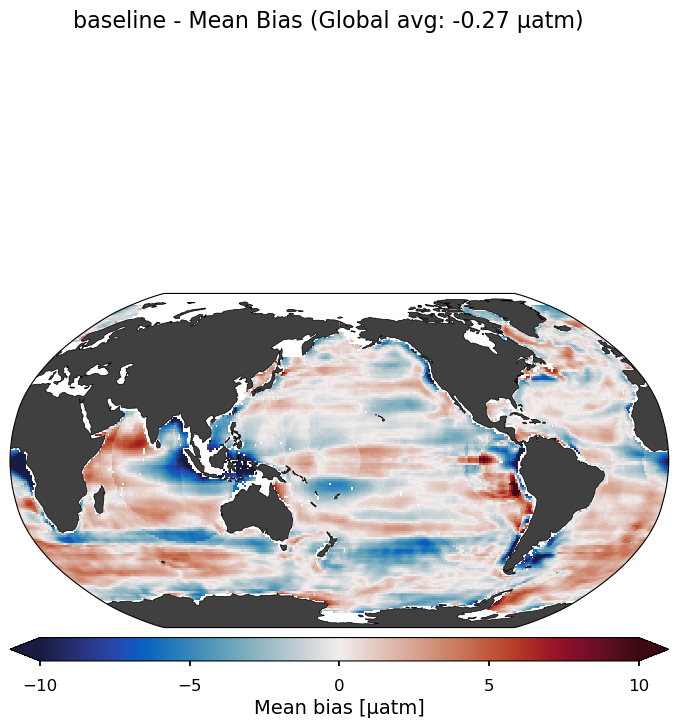


baseline - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.47 μatm
Southern Hemisphere (90S-0): -0.15 μatm
Tropics (23.5S-23.5N): -0.56 μatm
Southern Ocean (60S-35S): -0.18 μatm


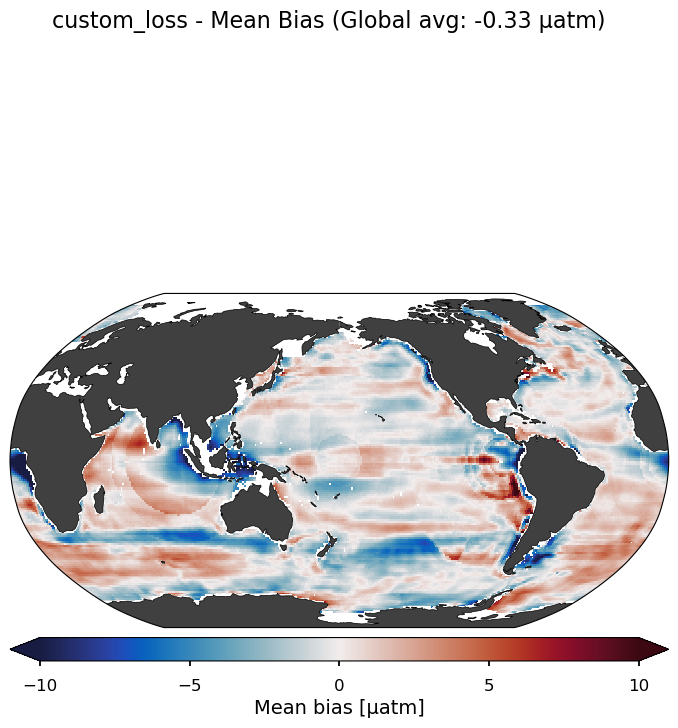


custom_loss - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.60 μatm
Southern Hemisphere (90S-0): -0.18 μatm
Tropics (23.5S-23.5N): -0.48 μatm
Southern Ocean (60S-35S): -0.28 μatm


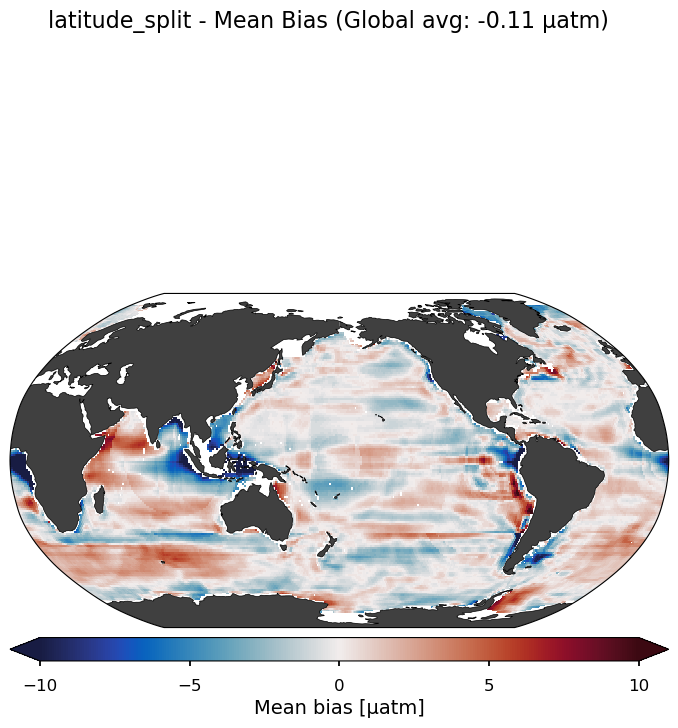


latitude_split - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.43 μatm
Southern Hemisphere (90S-0): 0.07 μatm
Tropics (23.5S-23.5N): -0.45 μatm
Southern Ocean (60S-35S): 0.33 μatm


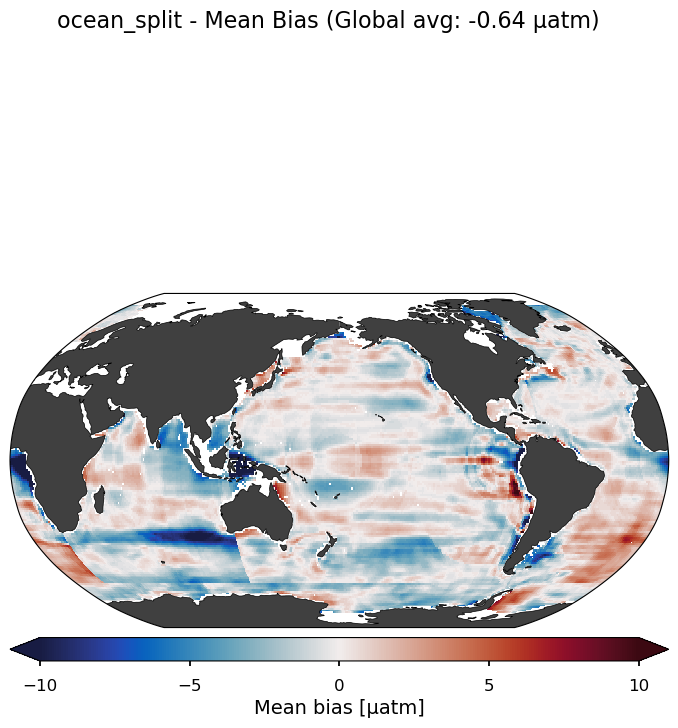


ocean_split - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.58 μatm
Southern Hemisphere (90S-0): -0.67 μatm
Tropics (23.5S-23.5N): -0.66 μatm
Southern Ocean (60S-35S): -0.88 μatm


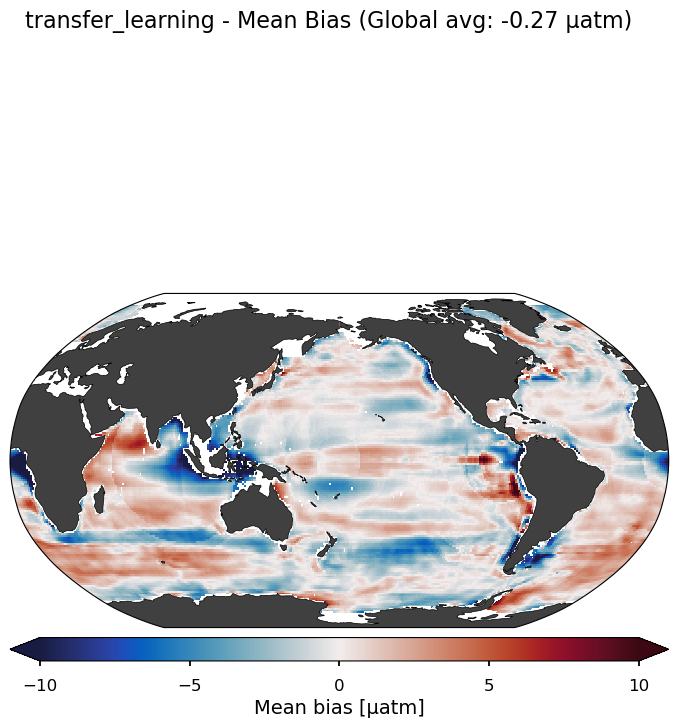


transfer_learning - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.46 μatm
Southern Hemisphere (90S-0): -0.16 μatm
Tropics (23.5S-23.5N): -0.57 μatm
Southern Ocean (60S-35S): -0.16 μatm


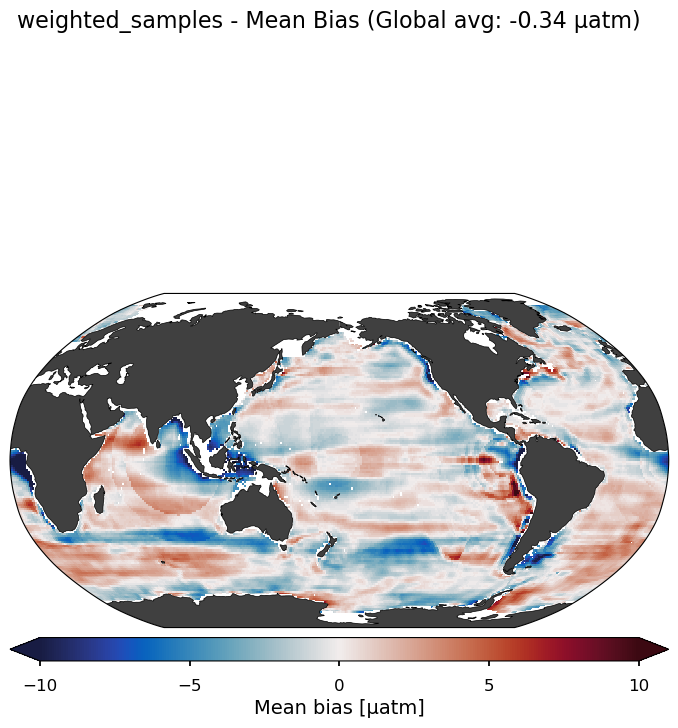


weighted_samples - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.61 μatm
Southern Hemisphere (90S-0): -0.18 μatm
Tropics (23.5S-23.5N): -0.51 μatm
Southern Ocean (60S-35S): -0.28 μatm


In [6]:
# 5.1 Compare mean bias across approaches
def plot_bias_comparison(eval_results):
    """Plot mean bias comparison across approaches in the same style as the starter notebook"""
    plot_style = "seaborn-v0_8-talk"
    
    # Create a figure for each approach
    for approach, ds_eval in eval_results.items():
        with plt.style.context(plot_style):
            fig = plt.figure(figsize=(8.5, 11))
            worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
            
            # Set consistent colorbar range as in starter notebook
            vrange = [-10, 10, 5] 
            cmap = cm.cm.balance
            
            # Calculate mean bias
            data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
            data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
            
            data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
            sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                   vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
            
            # Add colorbar
            col = worldmap.add_colorbar(sub, ax=0, extend='both')
            worldmap.set_cbar_xlabel(col, 'Mean bias [μatm]', fontsize=14)
            worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
            col.ax.tick_params(labelsize=12)
            
            # Set title
            global_mean = float(data.mean())
            plt.suptitle(f"{approach} - Mean Bias (Global avg: {global_mean:.2f} μatm)", 
                         fontsize=16, y=0.92)
            
            plt.savefig(f'bias_{approach}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Print regional statistics similar to project3_starter.py
            print(f"\n{approach} - Regional Bias Statistics:")
            print(f"Northern Hemisphere (0-90N): {data.sel(ylat=slice(0,90)).mean().values:.2f} μatm")
            print(f"Southern Hemisphere (90S-0): {data.sel(ylat=slice(-90,0)).mean().values:.2f} μatm")
            print(f"Tropics (23.5S-23.5N): {data.sel(ylat=slice(-23.5,23.5)).mean().values:.2f} μatm")
            print(f"Southern Ocean (60S-35S): {data.sel(ylat=slice(-60,-35)).mean().values:.2f} μatm")

print("Generating bias plots for each approach...")
plot_bias_comparison(eval_results)


Generating correlation plots for each approach...
baseline - Seasonal correlation mean: 0.900
baseline - Sub-decadal correlation mean: 0.617
baseline - Decadal correlation mean: 0.580


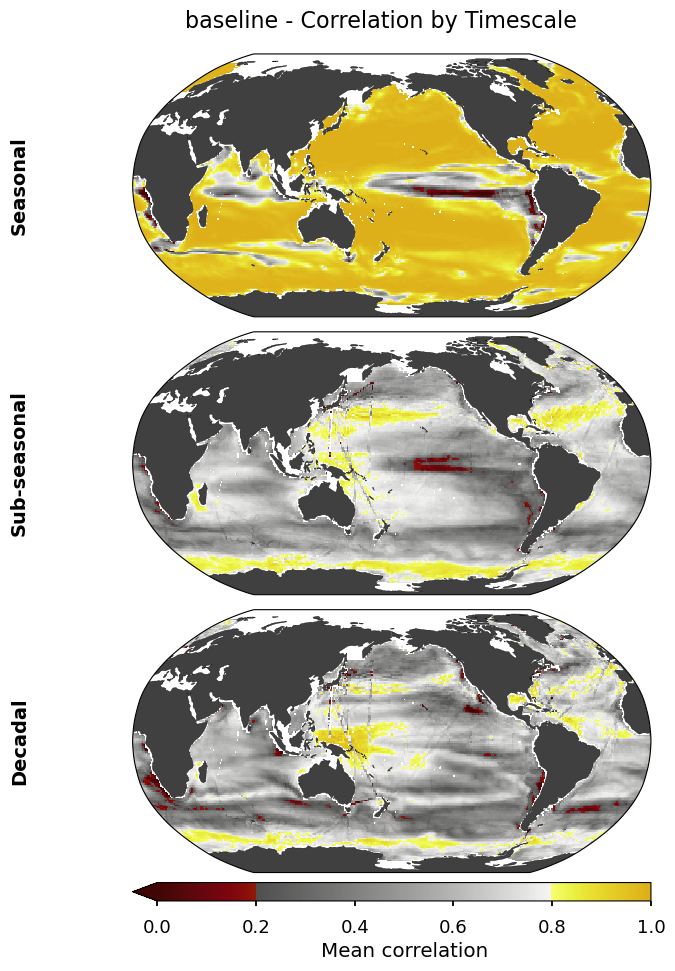

custom_loss - Seasonal correlation mean: 0.899
custom_loss - Sub-decadal correlation mean: 0.596
custom_loss - Decadal correlation mean: 0.572


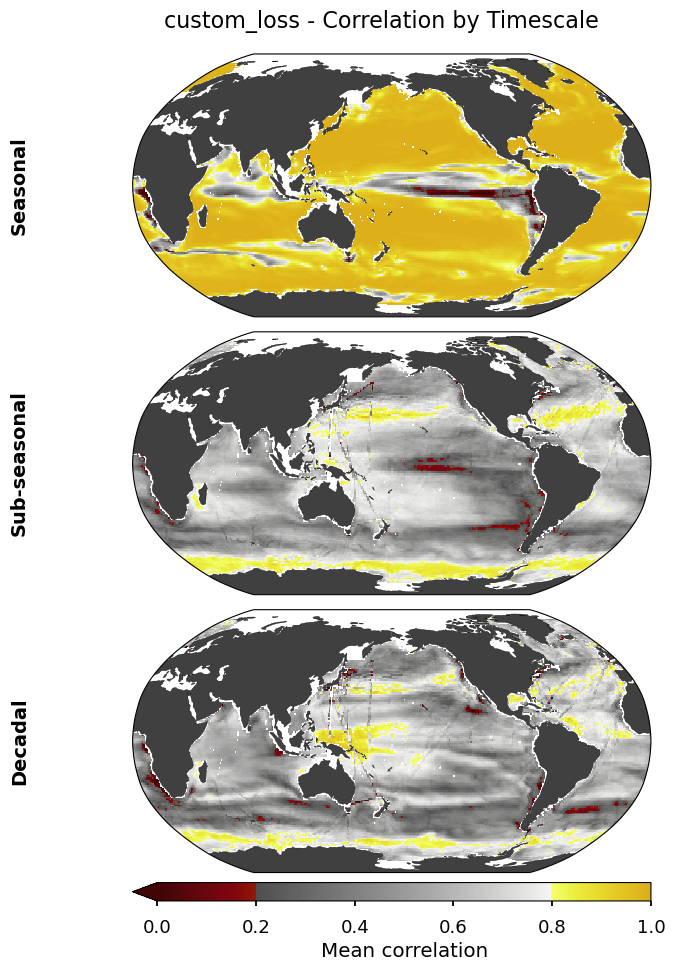

latitude_split - Seasonal correlation mean: 0.916
latitude_split - Sub-decadal correlation mean: 0.638
latitude_split - Decadal correlation mean: 0.620


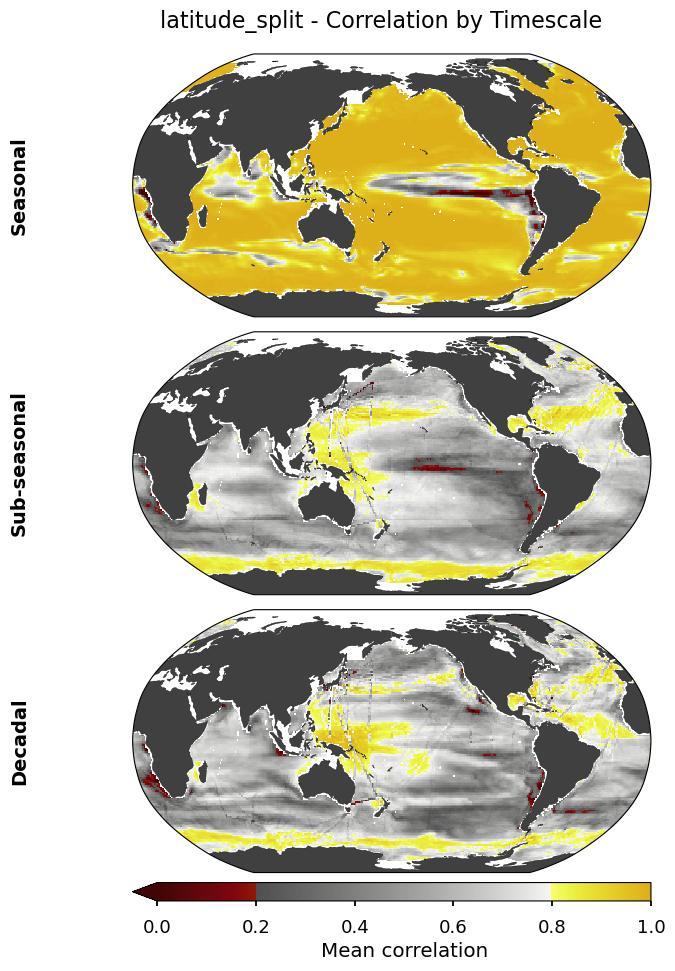

ocean_split - Seasonal correlation mean: 0.903
ocean_split - Sub-decadal correlation mean: 0.606
ocean_split - Decadal correlation mean: 0.582


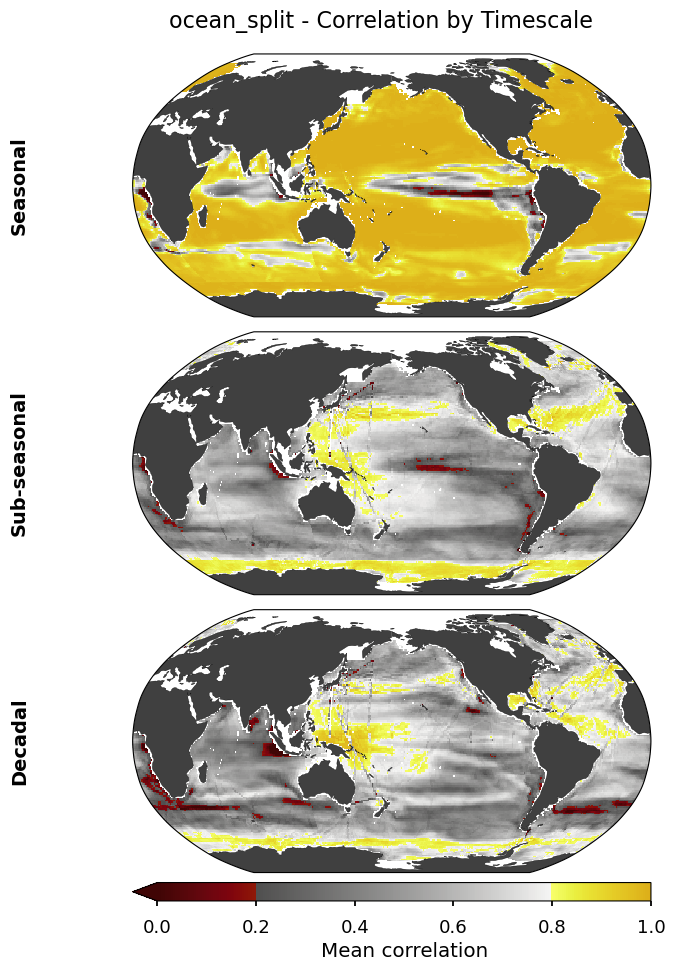

transfer_learning - Seasonal correlation mean: 0.899
transfer_learning - Sub-decadal correlation mean: 0.618
transfer_learning - Decadal correlation mean: 0.580


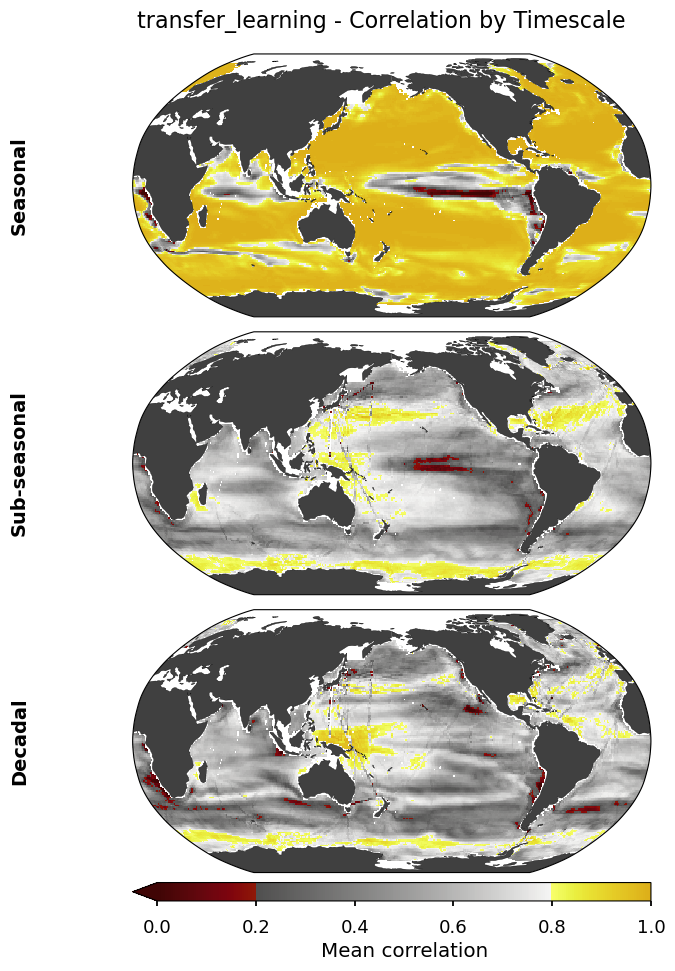

weighted_samples - Seasonal correlation mean: 0.900
weighted_samples - Sub-decadal correlation mean: 0.596
weighted_samples - Decadal correlation mean: 0.572


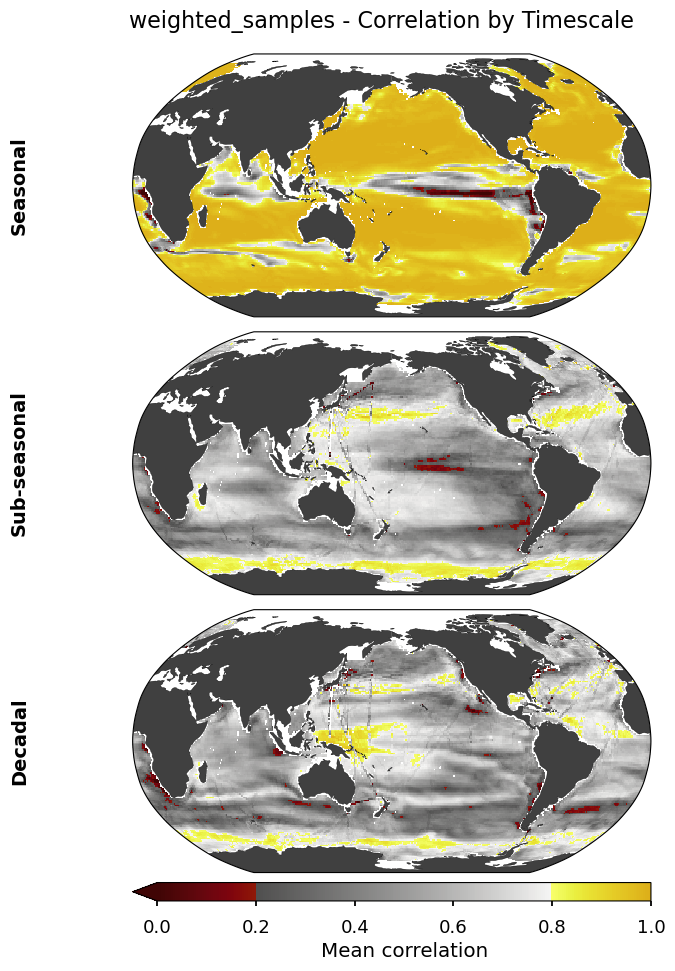

In [7]:
# 5.2 Plot correlation across timescales for each approach
def plot_correlation_by_approach(corr_results):
    """Plot correlation for seasonal, sub-decadal, and decadal timescales for each approach"""
    plot_style = "seaborn-v0_8-talk"
    timescales = ['seasonal', 'residual', 'dec']  # Match the timescales used in eval_spatial
    timescale_labels = ['Seasonal', 'Sub-decadal', 'Decadal']
    
    for approach, ds_corr in corr_results.items():
        with plt.style.context(plot_style):
            # Setup Figure
            fig = plt.figure(figsize=(8.5, 11))
            worldmap = SpatialMap2(fig=fig, region='world',
                           cbar_mode='edge',
                           axes_pad=0.15,
                           colorbar=True,
                           cbar_location='bottom',
                           nrows_ncols=[3,1])
            
            # Colorbar ranges (matching starter notebook)
            vrange_col1 = [0, 1, 0.2]
            cmap_col1 = cm.cm.oxy
            
            # Plot correlation for each timescale
            for i, (timescale, label) in enumerate(zip(timescales, timescale_labels)):
                corr_var = f'corr_{timescale}'
                if corr_var in ds_corr:
                    data = ds_corr[corr_var].mean('ens').mean('member')
                    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
                    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
                    
                    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                          vrange=vrange_col1[0:2], cmap=cmap_col1, ax=i)
                    
                    # Calculate and print global mean correlation
                    global_mean = float(data.mean())
                    print(f"{approach} - {label} correlation mean: {global_mean:.3f}")
                else:
                    print(f"Warning: {corr_var} not found for {approach}")
            
            # Add colorbar and labels
            col1 = worldmap.add_colorbar(sub, ax=0, extend='min')
            worldmap.set_cbar_xlabel(col1, f'Mean correlation')
            worldmap.set_ticks(col1, vrange_col1[0], vrange_col1[1], vrange_col1[2])
            
            # Add side labels for each timescale, matching the starter notebook
            worldmap.grid[0].text(-0.2, 0.5, "Seasonal", transform=worldmap.grid[0].transAxes,
                                 fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
            
            worldmap.grid[1].text(-0.2, 0.5, "Sub-seasonal", transform=worldmap.grid[1].transAxes,
                                 fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
            
            worldmap.grid[2].text(-0.2, 0.5, "Decadal", transform=worldmap.grid[2].transAxes,
                                 fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
            
            plt.suptitle(f"{approach} - Correlation by Timescale", fontsize=16, y=0.92)
            plt.savefig(f'correlation_{approach}.png', dpi=300, bbox_inches='tight')
            plt.show()

print("\nGenerating correlation plots for each approach...")
plot_correlation_by_approach(corr_results)


Generating RMSE plots for each approach...


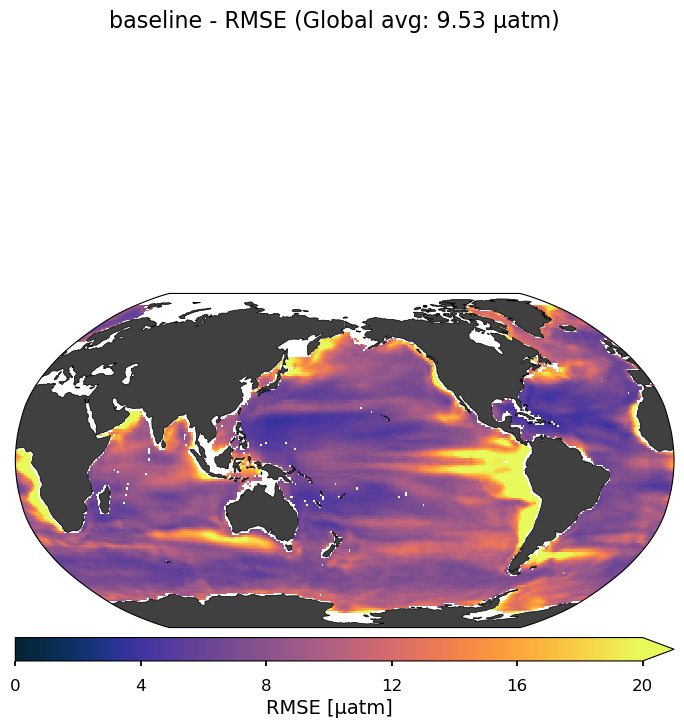


baseline - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 9.10 μatm
Southern Hemisphere (90S-0): 9.77 μatm
Tropics (23.5S-23.5N): 9.64 μatm
Southern Ocean (60S-35S): 9.05 μatm


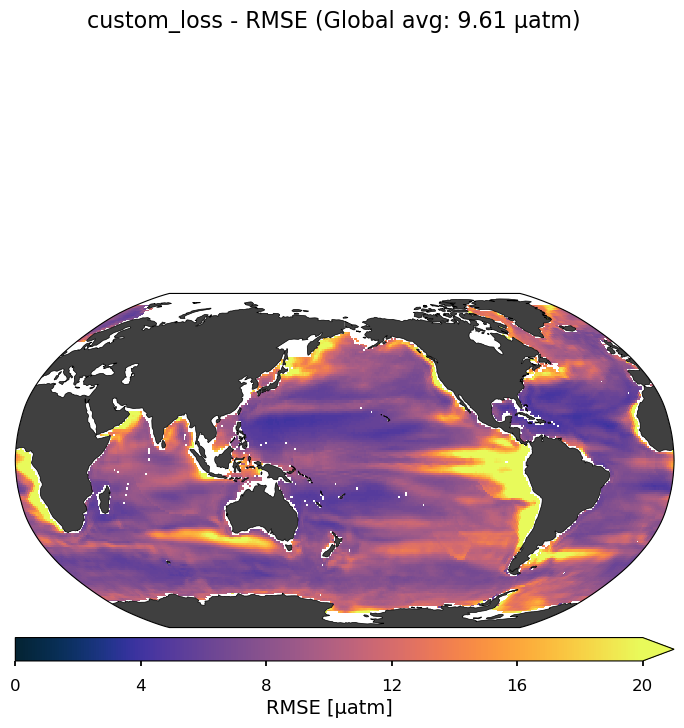


custom_loss - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 9.24 μatm
Southern Hemisphere (90S-0): 9.82 μatm
Tropics (23.5S-23.5N): 9.66 μatm
Southern Ocean (60S-35S): 9.18 μatm


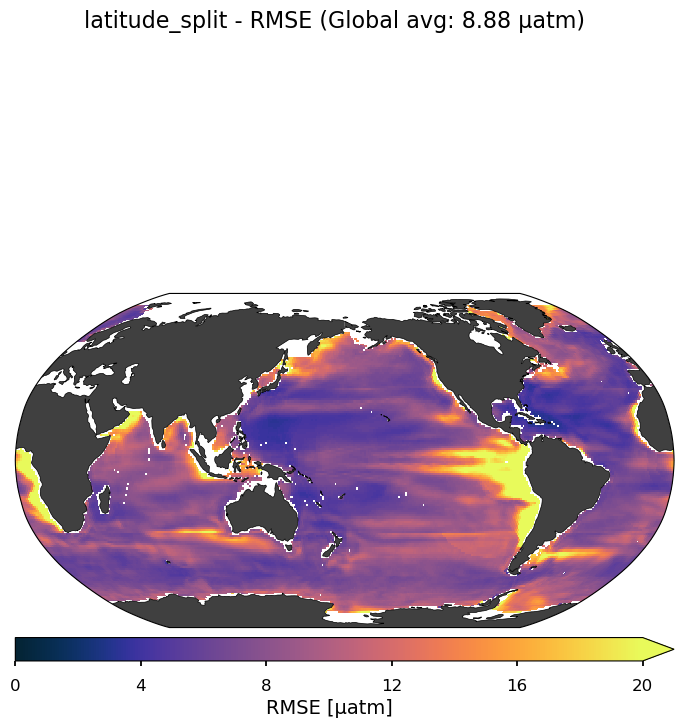


latitude_split - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 8.34 μatm
Southern Hemisphere (90S-0): 9.18 μatm
Tropics (23.5S-23.5N): 9.15 μatm
Southern Ocean (60S-35S): 8.31 μatm


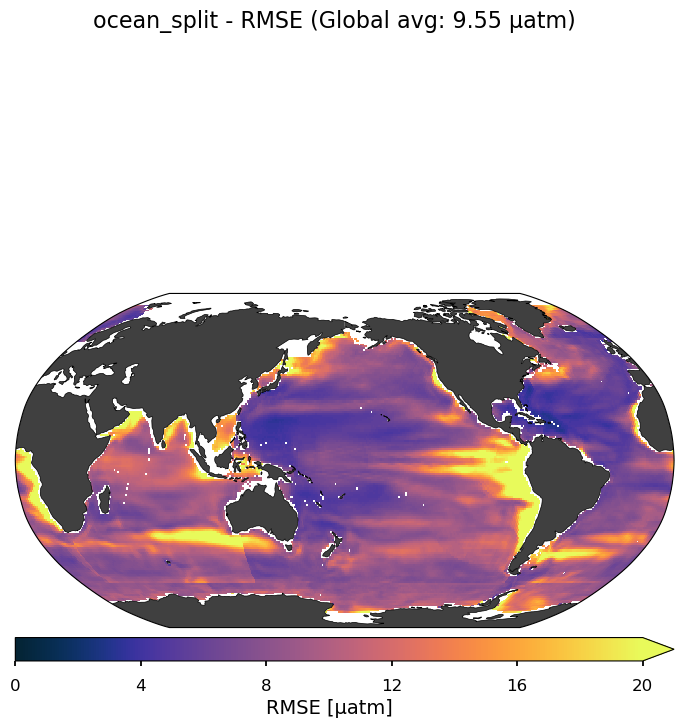


ocean_split - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 8.59 μatm
Southern Hemisphere (90S-0): 10.09 μatm
Tropics (23.5S-23.5N): 9.59 μatm
Southern Ocean (60S-35S): 9.95 μatm


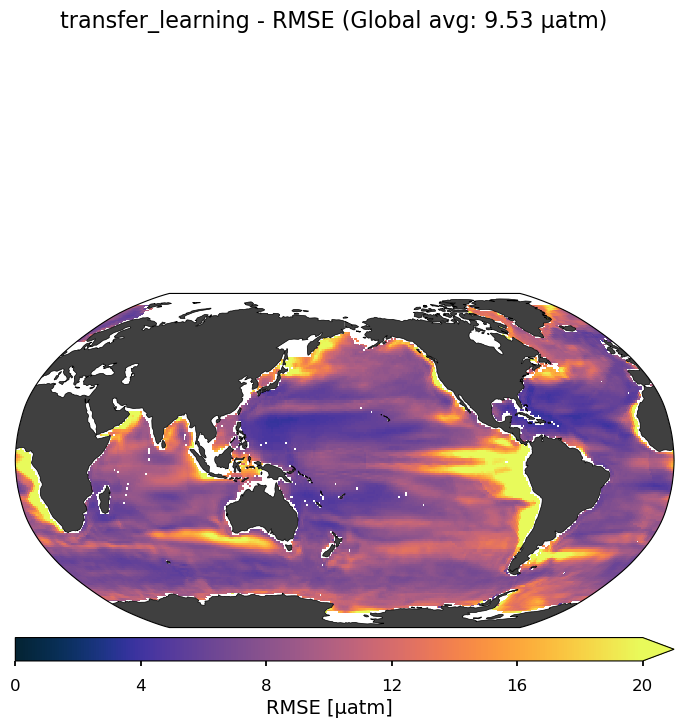


transfer_learning - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 9.09 μatm
Southern Hemisphere (90S-0): 9.78 μatm
Tropics (23.5S-23.5N): 9.63 μatm
Southern Ocean (60S-35S): 9.07 μatm


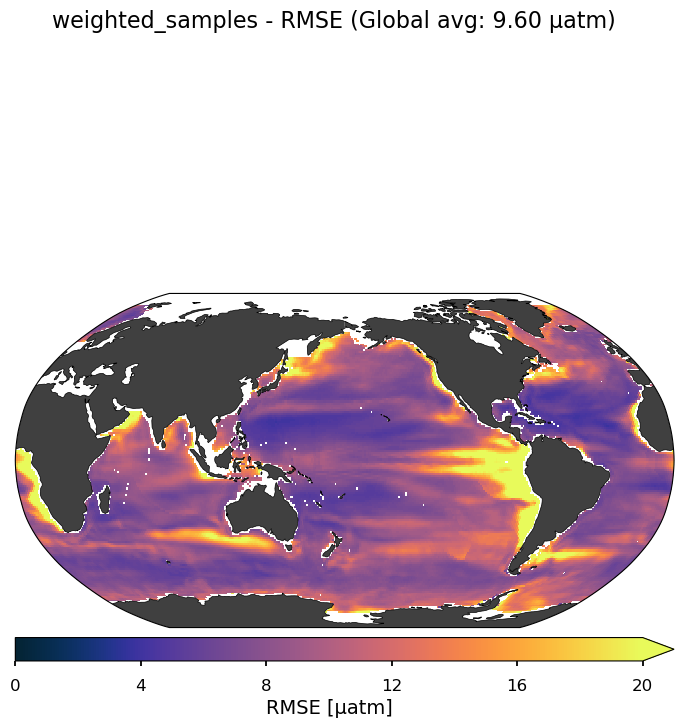


weighted_samples - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 9.24 μatm
Southern Hemisphere (90S-0): 9.80 μatm
Tropics (23.5S-23.5N): 9.64 μatm
Southern Ocean (60S-35S): 9.16 μatm


In [8]:
# 5.3 Plot RMSE for each approach
def plot_rmse_by_approach(eval_results):
    """Plot RMSE for each approach"""
    plot_style = "seaborn-v0_8-talk"
    
    for approach, ds_eval in eval_results.items():
        with plt.style.context(plot_style):
            fig = plt.figure(figsize=(8.5, 11))
            worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
            
            # Set consistent colorbar range
            vrange = [0, 20, 4] 
            cmap = cm.cm.thermal
            
            # Calculate mean RMSE
            data = ds_eval['rmse'].mean('ens').mean('member')
            data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
            
            data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
            sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                   vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
            
            # Add colorbar
            col = worldmap.add_colorbar(sub, ax=0, extend='max')
            worldmap.set_cbar_xlabel(col, 'RMSE [μatm]', fontsize=14)
            worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
            col.ax.tick_params(labelsize=12)
            
            # Set title
            global_mean = float(data.mean())
            plt.suptitle(f"{approach} - RMSE (Global avg: {global_mean:.2f} μatm)", 
                       fontsize=16, y=0.92)
            
            plt.savefig(f'rmse_{approach}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Print regional statistics
            print(f"\n{approach} - Regional RMSE Statistics:")
            print(f"Northern Hemisphere (0-90N): {data.sel(ylat=slice(0,90)).mean().values:.2f} μatm")
            print(f"Southern Hemisphere (90S-0): {data.sel(ylat=slice(-90,0)).mean().values:.2f} μatm")
            print(f"Tropics (23.5S-23.5N): {data.sel(ylat=slice(-23.5,23.5)).mean().values:.2f} μatm")
            print(f"Southern Ocean (60S-35S): {data.sel(ylat=slice(-60,-35)).mean().values:.2f} μatm")

print("\nGenerating RMSE plots for each approach...")
plot_rmse_by_approach(eval_results)

## Lat, Lon Averages by Method

In [107]:
def add_horizontal_shading(y_ranges, colors, labels, labeling=False):
    for (y_min, y_max), color, label in zip(y_ranges, colors, labels):
        plt.fill_betweenx([y_min, y_max], plt.xlim()[0], plt.xlim()[1], color=color, alpha=0.2)
        if labeling:
            mid_point = (y_min + y_max) / 2 
            plt.text(plt.xlim()[1] * 0.95, mid_point, label, color=color, fontsize=10, va='center')


y_ranges = [(30,110), (-70, 20), (150, 180), (-180, -100)]
colors = ['blue', 'green', 'red', 'red']
labels = ['Indian Ocean', 'Atlantic Ocean', 'Pacific Ocean', 'Pacific Ocean']

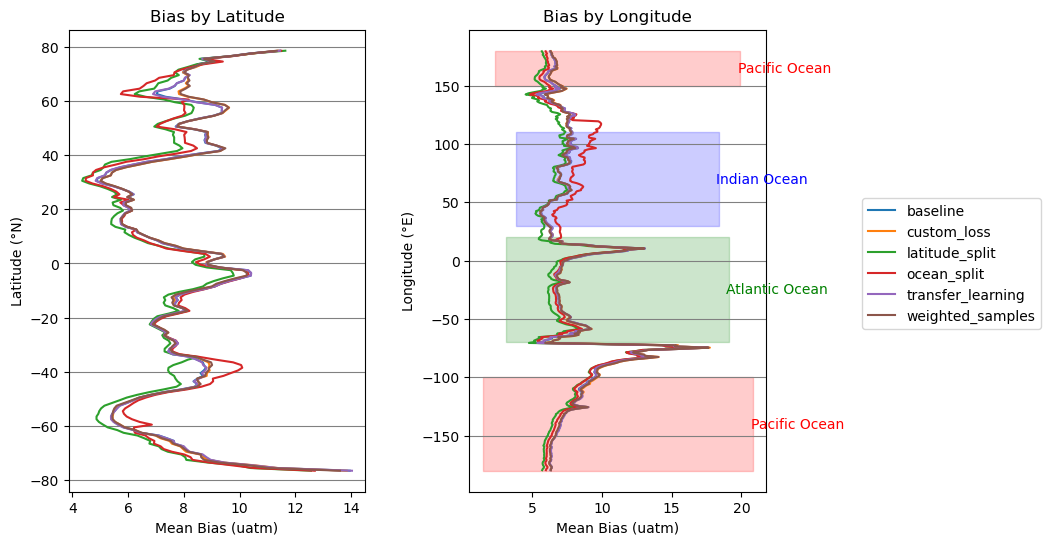

CPU times: user 3min 9s, sys: 14.5 s, total: 3min 23s
Wall time: 1min 46s


In [138]:
%%time
plt.figure(figsize=(9,6))

plt.subplot(121)
for method in eval_results.keys():
    ds_method = eval_results[method]
    np.abs(ds_method['bias']).mean(['member','time','xlon', 'ens']).plot(y='ylat', label=method)
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Mean Bias (uatm)')
plt.title('Bias by Latitude')

plt.subplot(122)
for method in eval_results.keys():
    ds_method = eval_results[method]
    np.abs(ds_method['bias']).mean(['member','time','ylat', 'ens']).plot(y='xlon', label=method)
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3,0.65])
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Mean Bias (uatm)')
plt.title('Bias by Longitude')

plt.subplots_adjust(wspace=0.35)  

plt.show();

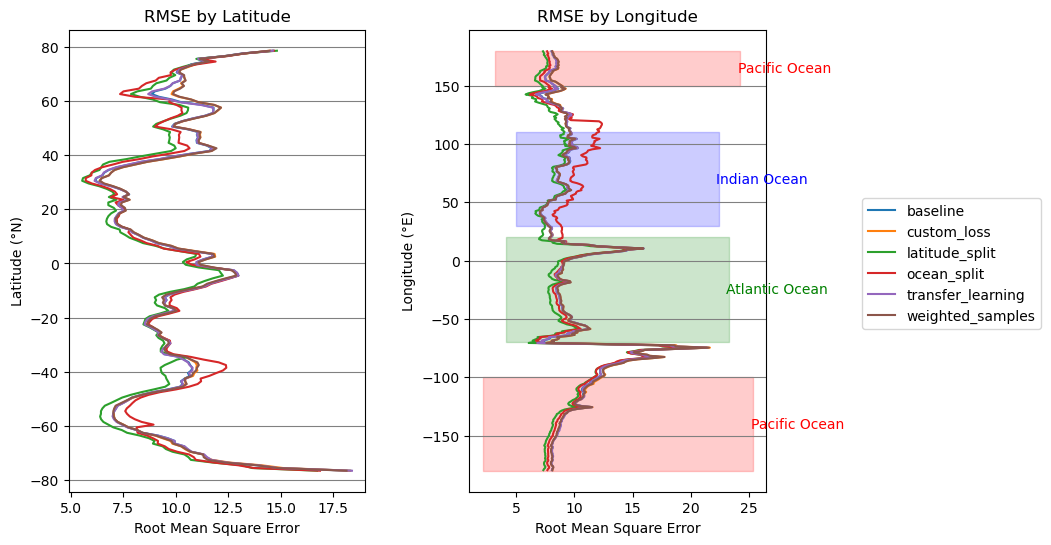

CPU times: user 3min 13s, sys: 16.1 s, total: 3min 29s
Wall time: 1min 52s


In [137]:
%%time
plt.figure(figsize=(9,6))

plt.subplot(121)
for method in eval_results.keys():
    ds_method = eval_results[method]
    np.abs(ds_method['rmse']).mean(['member','xlon', 'ens']).plot(y='ylat', label=method)
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Root Mean Square Error')
plt.title('RMSE by Latitude')

plt.subplot(122)
for method in eval_results.keys():
    ds_method = eval_results[method]
    np.abs(ds_method['rmse']).mean(['member','ylat', 'ens']).plot(y='xlon', label=method)
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3, 0.65])
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Root Mean Square Error')
plt.title('RMSE by Longitude')

plt.subplots_adjust(wspace=0.35)  

plt.show();

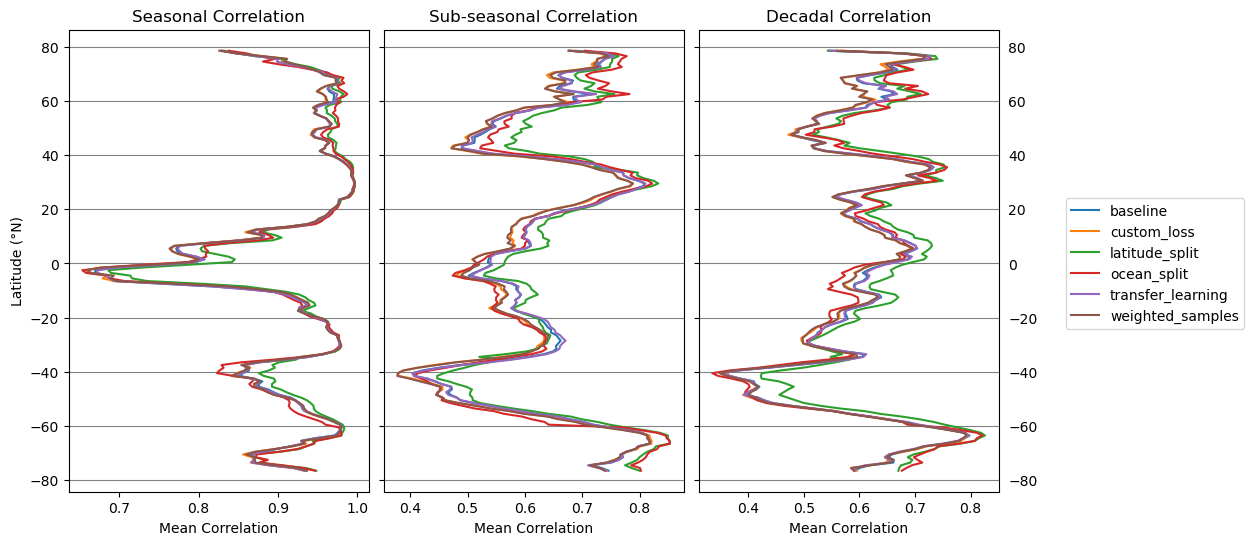

CPU times: user 612 ms, sys: 168 ms, total: 780 ms
Wall time: 455 ms


In [136]:
%%time
plt.figure(figsize=(12,6))

plt.subplot(131)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_seasonal']).mean(['member','xlon', 'ens']).plot(y='ylat', label=method)
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Mean Correlation')
plt.title('Seasonal Correlation')

plt.subplot(132)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_residual']).mean(['member','xlon', 'ens']).plot(y='ylat', label=method)
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Sub-seasonal Correlation')

plt.subplot(133)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_dec']).mean(['member','xlon', 'ens']).plot(y='ylat', label=method)
plt.legend(bbox_to_anchor = [1.2, 0.65])
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False, labelright=True)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Decadal Correlation')

plt.subplots_adjust(wspace=0.05)
plt.show();

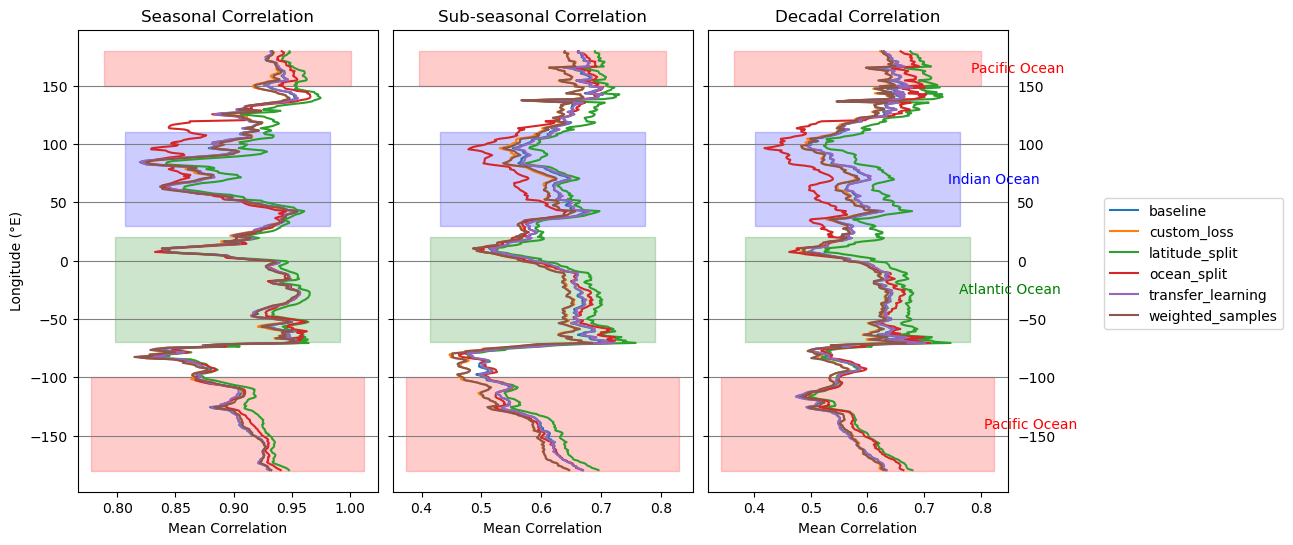

CPU times: user 708 ms, sys: 152 ms, total: 860 ms
Wall time: 537 ms


In [134]:
%%time
plt.figure(figsize=(12,6))

plt.subplot(131)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_seasonal']).mean(['member','ylat', 'ens']).plot(y='xlon', label=method)
add_horizontal_shading(y_ranges, colors, labels)
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Mean Correlation')
plt.title('Seasonal Correlation')

plt.subplot(132)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_residual']).mean(['member','ylat', 'ens']).plot(y='xlon', label=method)
add_horizontal_shading(y_ranges, colors, labels)
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Sub-seasonal Correlation')

plt.subplot(133)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_dec']).mean(['member','ylat', 'ens']).plot(y='xlon', label=method)
plt.legend(bbox_to_anchor = [1.3, 0.65])
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False, labelright=True)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Decadal Correlation')

plt.subplots_adjust(wspace=0.05)
plt.show();

## Lat, Lon Averages by ESM for the `latitude_split` method

In [62]:
color_dict = {'ACCESS-ESM1-5': ['indianred','maroon'],
              'CanESM5': ['yellowgreen','darkgreen'],
              'MPI-ESM1-2-LR': ['skyblue','navy']}

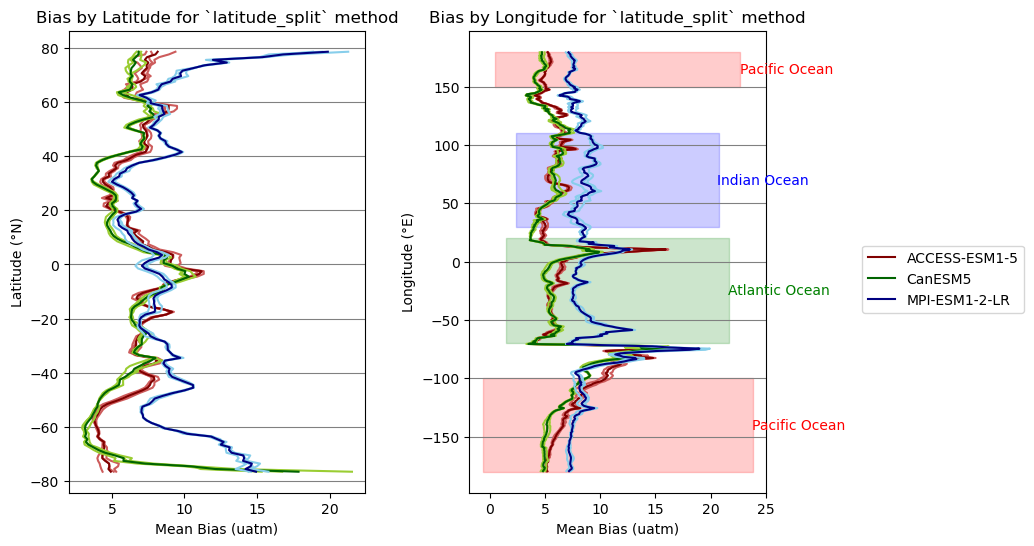

CPU times: user 40.3 s, sys: 3.69 s, total: 44 s
Wall time: 29.2 s


In [132]:
%%time
plt.figure(figsize=(9,6))

plt.subplot(121)
ds_method = eval_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['bias'].isel(member=0)).mean(['time','xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['bias'].isel(member=1)).mean(['time','xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['bias'].isel(member=2)).mean(['time','xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['bias']).mean(['member','time','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Mean Bias (uatm)')
plt.title('Bias by Latitude for `latitude_split` method')

plt.subplot(122)
ds_method = eval_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['bias'].isel(member=0)).mean(['time','ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['bias'].isel(member=1)).mean(['time','ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['bias'].isel(member=2)).mean(['time','ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['bias']).mean(['member','time','ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3, 0.55])
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Mean Bias (uatm)')
plt.title('Bias by Longitude for `latitude_split` method')

plt.subplots_adjust(wspace=0.35)            

plt.show();

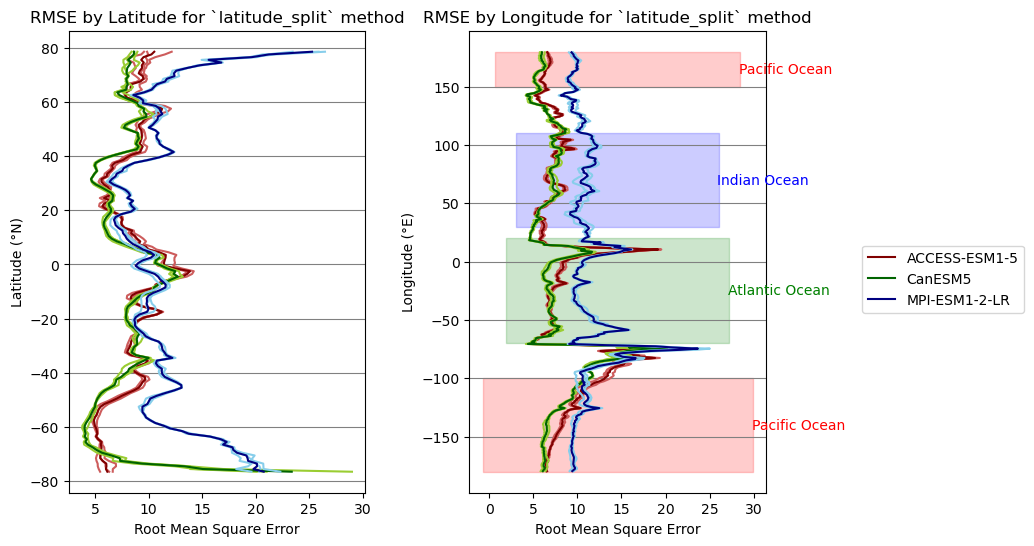

CPU times: user 38.7 s, sys: 3.66 s, total: 42.3 s
Wall time: 31 s


In [131]:
%%time
plt.figure(figsize=(9,6))

plt.subplot(121)
ds_method = eval_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['rmse'].isel(member=0)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['rmse'].isel(member=1)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['rmse'].isel(member=2)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['rmse']).mean(['member','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Root Mean Square Error')
plt.title('RMSE by Latitude for `latitude_split` method')

plt.subplot(122)
ds_method = eval_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['rmse'].isel(member=0)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['rmse'].isel(member=1)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['rmse'].isel(member=2)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['rmse']).mean(['member','ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3,0.55])
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Root Mean Square Error')
plt.title('RMSE by Longitude for `latitude_split` method')

plt.subplots_adjust(wspace=0.35)            

plt.show();

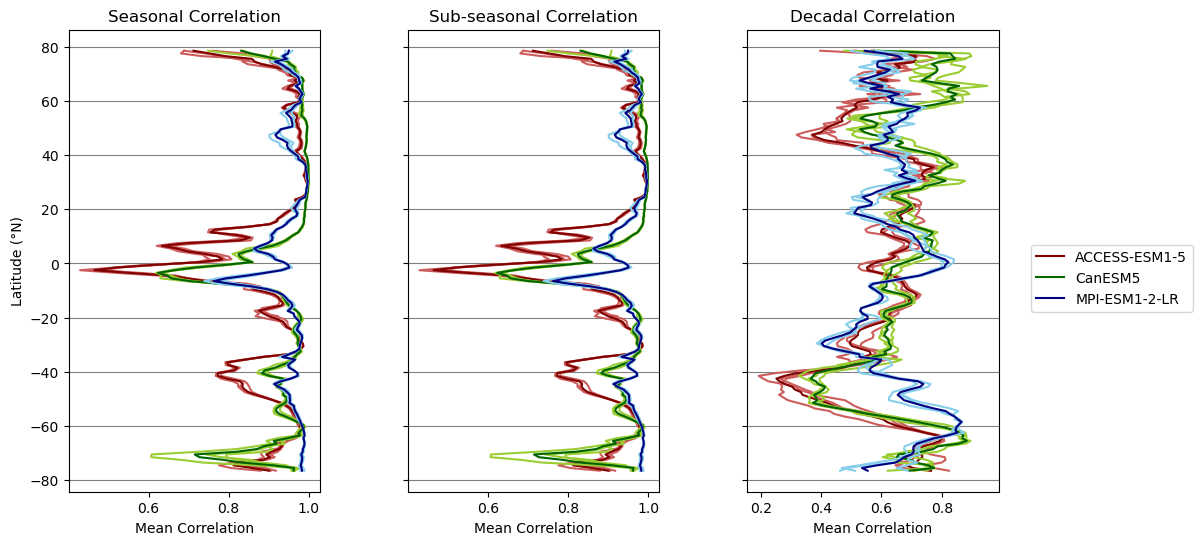

CPU times: user 605 ms, sys: 157 ms, total: 761 ms
Wall time: 483 ms


In [129]:
%%time
plt.figure(figsize=(12,6))

plt.subplot(131)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_seasonal'].isel(member=0)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=1)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=2)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal']).mean(['member','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Mean Correlation')
plt.title('Seasonal Correlation')

plt.subplot(132)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_seasonal'].isel(member=0)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=1)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=2)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal']).mean(['member','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Sub-seasonal Correlation')


plt.subplot(133)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_dec'].isel(member=0)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec'].isel(member=1)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec'].isel(member=2)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec']).mean(['member','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.legend(bbox_to_anchor = [1.1, 0.55])
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Decadal Correlation')

plt.subplots_adjust(wspace=0.35)            

plt.show();

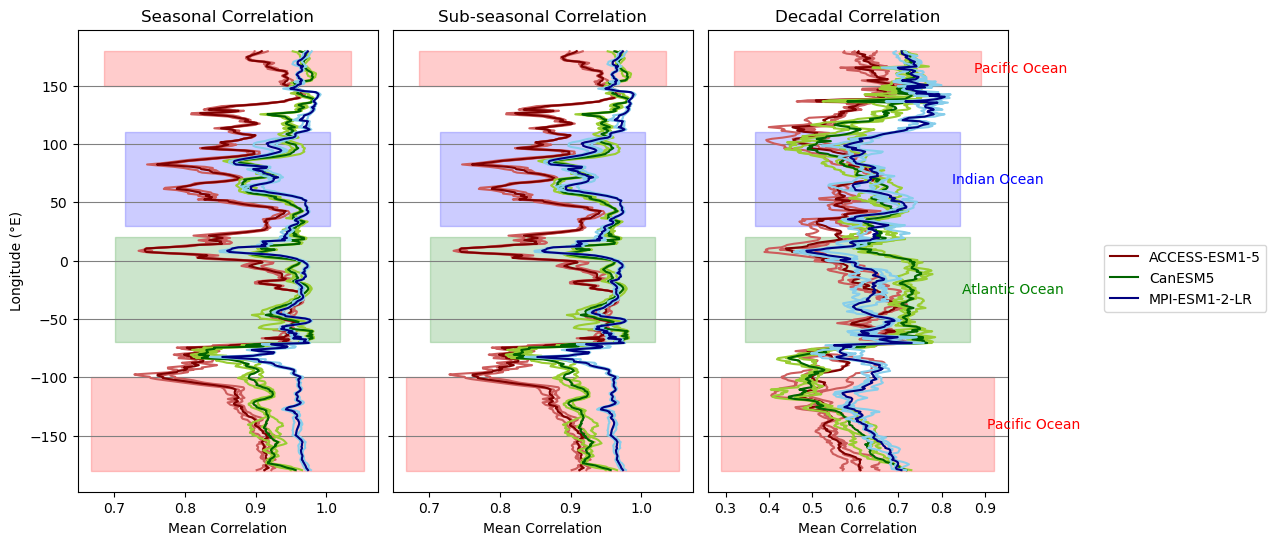

CPU times: user 753 ms, sys: 261 ms, total: 1.01 s
Wall time: 552 ms


In [130]:
%%time
plt.figure(figsize=(12, 6))

plt.subplot(131)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_seasonal'].isel(member=0)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=1)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=2)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal']).mean(['member', 'ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels)
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Mean Correlation')
plt.title('Seasonal Correlation')

plt.subplot(132)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_seasonal'].isel(member=0)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=1)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=2)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal']).mean(['member', 'ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels)
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Sub-seasonal Correlation')

plt.subplot(133)
ds_method = corr_results['latitude_split']
ax = plt.gca()  # Get the current axis
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_dec'].isel(member=0)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec'].isel(member=1)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec'].isel(member=2)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec']).mean(['member', 'ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3, 0.55])
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Decadal Correlation')

plt.subplots_adjust(wspace=0.05)

plt.show()

In [ ]:
import pickle
import os

# Create a directory to save results if it doesn't exist
output_dir = base_path+'/analysis_results'
if not fs.exists(output_dir):
    fs.mkdir(output_dir)

# Save eval_results as pickle
with fs.open(f'{output_dir}/eval_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)
    
# Save corr_results as pickle
with fs.open(f'{output_dir}/corr_results.pkl', 'wb') as f:
    pickle.dump(corr_results, f)

print(f"Results saved to {output_dir}")

In [10]:
runthiscell = 1

from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = output_dir
    blobs = bucket.list_blobs(prefix=prefix)
    
    seen_dirs = set()  # Track top-level directories (immediate subdirectories of `reconstructions`)

    for blob in blobs:
        # Extract the relative path after `reconstructions/`
        relative_path = blob.name[len(prefix):]
        top_level_dir = relative_path.split("/")[0]  # Get first component

        try:
            # Make the file public
            blob.make_public()
            
            # Only print if it's a new top-level directory
            if top_level_dir not in seen_dirs:
                seen_dirs.add(top_level_dir)
                print(f"Made public: {top_level_dir}")
        except Exception as e:
            print(f"Failed to make public: {blob.name}")
            print(e)

In [ ]:
# output_dir = base_path+'/analysis_results'

# with fs.open(f'{output_dir}/eval_results.pkl', 'rb') as f:
#     eval_results = pickle.load(f)
    
# with fs.open(f'{output_dir}/corr_results.pkl', 'rb') as f:
#     corr_results = pickle.load(f)